<a href="https://colab.research.google.com/github/aemanmuneeb/Optimizing-a-Linear-Time-Invariant-State-Space-Model-in-SciPy/blob/main/UW_Madison_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download uw-madison-gi-tract-image-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 2.27G/2.30G [00:15<00:00, 195MB/s]
100% 2.30G/2.30G [00:15<00:00, 159MB/s]


In [2]:
import shutil
shutil.unpack_archive("/content/uw-madison-gi-tract-image-segmentation.zip", "uw-madison-gi-tract-image-segmentation")

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from matplotlib import pyplot as plt
from imageio import imread
from glob import glob

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

Tensorflow version 2.8.2


In [4]:
df = pd.read_csv("/content/uw-madison-gi-tract-image-segmentation/train.csv")
df = df.fillna('0')

In [5]:
#Preprocess dataset and get relevant colums of information
df['CaseID'] = df.id.apply(lambda x : str(x).split("_")[0][4:])
df['Day'] = df.id.apply(lambda x : str(x).split("_")[1][3:])
df['SliceNo'] = df.id.apply(lambda x : str(x).split("_")[3])

train_path = "/content/uw-madison-gi-tract-image-segmentation/train"

def fetch_file(root_dir, id):
    cases = id.split("_")[0]
    days = "_".join(id.split("_")[:2])
    files = "_".join(id.split("_")[2:])
    folder = os.path.join(root_dir, cases, days, "scans")
    file = glob(f"{folder}/{files}*")
    return file[0]
df["path"] = df["id"].apply(lambda x: fetch_file(train_path, x))

df["image_height"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
df["image_width"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")

df.head()


,id,class,segmentation,CaseID,Day,SliceNo,path,image_height,image_width
0,case123_day20_slice_0001,large_bowel,0,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,0,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,0,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,0,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,0,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266


In [6]:
def rle_decode(segmentation, image_width, image_height, image_class):
    s = segmentation.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in ((s[0::2]), s[1::2])]
    ends = starts + lengths
    mask = np.zeros(image_width*image_height, dtype=np.uint8)
    for start,end in zip(starts, ends):
        mask[start:end] = 1
    return mask.reshape(image_width,image_height)

In [7]:
masks = (df['segmentation'].tolist())
image_heights = (df['image_height'].tolist())
image_widths = (df['image_width'].tolist())
image_class = (df['class'].tolist())
path = (df['path'].tolist())

In [8]:
image_info = list(zip(masks, image_widths, image_heights, image_class))
processedMasks = list(map(lambda x : rle_decode(x[0], x[1], x[2], x[3]), image_info))

In [9]:
import cv2

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)    
    return image

In [10]:
train_images = list(map(lambda x : read_image(x), path))

stomach


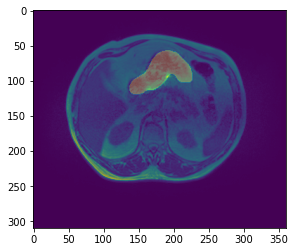

In [20]:
img_index = 41120

plt.imshow(train_images[img_index])
plt.imshow(processedMasks[img_index], alpha = 0.3)
print(image_info[img_index][3])

In [12]:
#allFiles = [path]

#'images/file1.txt', 'annotations/file1.txt'
#'images/file2.txt', 'annotations/file2.txt'

# for imageFile, annotationFile in zip(list(map(lambda x : os.path.join('images', x))), list(map(lambda x : os.path.join('annoations', x)))):
#   with open('images.txt', 'w') as imageFile, open('annotations.txt', 'w') as annotationFile:
#     annotationFile.write("something")

#with open('images.txt', 'w') as imageFile, open('annotations.txt', 'w') as annotationFile:
#  annotationFile.write("something")
